# Exogenous Process modeling - V1

## ETH price stochastic process

1. Acquire time series of tick-by-tick (or as-close-as) data for ETH price e.g. 2017-2020, e.g. [Kaggle Hourly Dataset](https://www.kaggle.com/prasoonkottarathil/ethereum-historical-dataset)
2. Fit a parametric distribution to the price of ETH, e.g. geometric Brownian motion, gamma distribution, gamma + Kalman fit (prediction) etc, resulting in a distribution $F^p_{ETH}(t; \mu_{ETH})$ and fitted parameters $\mu_{ETH}$.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import pandas as pd
from scipy.stats import gamma
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline

## Data preprocessing

In [2]:
# import data
historical_eth_hourly = pd.read_csv('data/ETH_1H.csv')
historical_eth_hourly.head(5)

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1586995200000,2020-04-16 00:00:00,ETHUSD,152.94,152.94,150.39,150.39,650.188125
1,1586991600000,2020-04-15 23:00:00,ETHUSD,155.81,155.81,151.39,152.94,4277.567299
2,1586988000000,2020-04-15 22:00:00,ETHUSD,157.18,157.30,155.32,155.81,106.337279
3,1586984400000,2020-04-15 21:00:00,ETHUSD,158.04,158.31,157.16,157.18,55.244131
4,1586980800000,2020-04-15 20:00:00,ETHUSD,157.10,158.10,156.87,158.04,144.262622


In [3]:
# sort by date from earliest to latest
sorted_historical_eth_hourly = historical_eth_hourly.sort_values(by='Date')

In [4]:
# add percentage change
sorted_historical_eth_hourly['Close_percentage_change'] = sorted_historical_eth_hourly['Close'].pct_change()

In [5]:
# replace early nan values with 0
sorted_historical_eth_hourly['Close_percentage_change'].fillna(0,inplace=True)

In [6]:
# split into training and test data. 
train, test= np.split(sorted_historical_eth_hourly, [int(.80 *len(sorted_historical_eth_hourly))])

<AxesSubplot:title={'center':'Eth hourly data percentage change'}, xlabel='Date'>

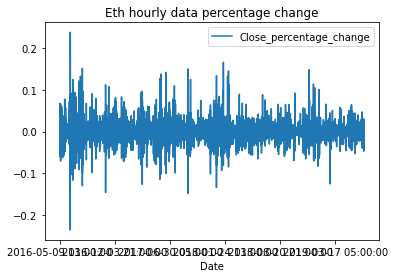

In [7]:
train.plot(x='Date',y='Close_percentage_change',title='Eth hourly data percentage change')

<AxesSubplot:title={'center':'Eth Hourly data'}, xlabel='Date'>

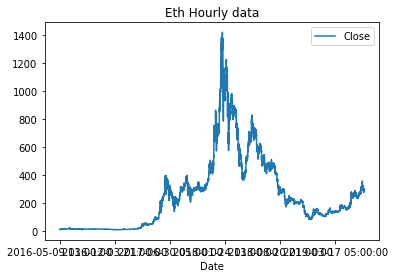

In [8]:
train.plot(x='Date',y='Close',title='Eth Hourly data')

## Gamma function

In [9]:
def gamma_distribution_fit(xhat):
    '''
    Description:
    Function to fit the data to the gamma distribution.
    
    Parameters:
    X: numpy array of values
    
    Example:
    fit_shape, fit_loc, fit_scale = gamma_distribution_fit(data,'subsidies')
    '''
    fit_shape, fit_loc, fit_scale =gamma.fit(xhat)
    return fit_shape, fit_loc, fit_scale


def gamma_sample(currentValue,fit_shape, fit_loc, fit_scale, tuning):
    '''
    Description:
    Function to sample data from a gamma distribution that has been previously
    fit and add current value to create a martingal process.
    
    Parameters:
    currentValue: float of current value, i.e. .254
    fit_shape: fit shape parameter
    fit_loc: fit location parameter
    fit_scale: fit scale parameter
    tuning: tuning value to make the gamma distribution not as jumpy
   
    Example: 
    sample = gamma_sample(value,fit_shape, fit_loc, fit_scale, 0.001)
    '''
    
    newValue = currentValue + (tuning*gamma.rvs(fit_shape, loc=fit_loc, scale=fit_scale, size=1)[0])
    return newValue


## Kalman filter

Kalman filters are a lightweight algorithm often in an economic context for reducing noise in signals. The Kalman Filter is trained on a subset of the data, and then the parameters are passed into a prediction function for use in subsequent samples. As Kalman filters are one step predictors, at each time step, the filters is retrained and the system state and parameters are updated. 

This implemention was refined by Andrew Clark in a [recent paper](https://ideas.repec.org/p/rdg/emxxdp/em-dp2020-22.html) that used Kalman filters embedded into a cadCAD model for forecasting exchange rates.

In [10]:
def kalman_filter(observations,initialValue,truthValues=None,plot=False,paramExport=False):
    '''
    Description:
    Function to create a Kalman Filter for smoothing currency timestamps in order to search for the
    intrinisic value.
    
    Parameters:
    observations: Array of observations, i.e. predicted secondary market prices.
    initialValue: Initial Starting value of filter
    truthValues: Array of truth values, i.e. GPS location or secondary market prices. Or can be left
    blank if none exist
    plot: If True, plot the observations, truth values and kalman filter.
    paramExport: If True, the parameters xhat,P,xhatminus,Pminus,K are returned to use in training.
    
    Example:
    xhat,P,xhatminus,Pminus,K = kalman_filter(observations=train.Close.values[0:-1],
                                              initialValue=train.Close.values[-1],paramExport=True)
    '''
    # intial parameters
    n_iter = len(observations)
    sz = (n_iter,) # size of array
    if isinstance(truthValues,np.ndarray):
        x = truthValues # truth value
    z = observations# observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.1**2 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = initialValue
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    if plot==True:
        plt.figure()
        plt.plot(z,'k+',label='Gamma distribution predictions')
        plt.plot(xhat,'b-',label='a posteri estimate')
        if isinstance(truthValues,np.ndarray):
            plt.plot(x,color='g',label='truth value')
        plt.legend()
        plt.title('Kalman Filter Estimates', fontweight='bold')
        plt.xlabel('Iteration')
        plt.ylabel('USD')
        plt.show()

    if paramExport==True:
        return  xhat,P,xhatminus,Pminus,K

    else:

        return xhat

def kalman_filter_predict(xhat,P,xhatminus,Pminus,K,observations,truthValues=None,paramExport=False):
    '''
    Description:
    Function to predict a pre-trained Kalman Filter 1 step forward.
    
    Parameters:
    xhat: Trained Kalman filter values - array
    P: Trained Kalman variance - array
    xhatminus: Trained Kalman xhat delta - array
    Pminus: Trained Kalman variance delta - array
    K: Kalman gain - array
    observations: Array of observations, i.e. predicted secondary market prices.
    truthValues: Array of truth values, i.e. GPS location or secondary market prices. Or can be left
    blank if none exist
    paramExport: If True, the parameters xhat,P,xhatminus,Pminus,K are returned to use in next predicted step.
    
    Example:
    xhat,P,xhatminus,Pminus,K = kalman_filter_predict(xhatInput,PInput,
                                                      xhatminusInput,PminusInput,KInput,observation,
                                                       paramExport=True)
    '''
    # intial parameters
    if isinstance(truthValues,np.ndarray):
        x = truthValues # truth value
    z = observations# observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    R = 0.03**2 # estimate of measurement variance, change to see effect


    # time update
    xhatminus = np.append(xhatminus,xhat[-1])
    Pminus = np.append(Pminus,P[-1]+Q)

    # measurement update
    K = np.append(K,Pminus[-1]/( Pminus[-1]+R ))
    xhat = np.append(xhat,xhatminus[-1]+K[-1]*(z[-1]-xhatminus[-1]))
    P = np.append(P,(1-K[-1])*Pminus[-1])

    if paramExport==True:
        return  xhat,P,xhatminus,Pminus,K

    else:

        return xhat

## Process training

Train the Kalman filter and fit the gamma distribution off of the training data.

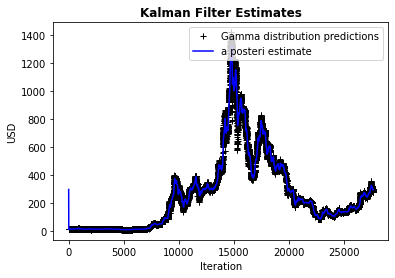

In [11]:
# train kalman
xhat,P,xhatminus,Pminus,K = kalman_filter(observations=train.Close.values[0:-1],
                                          initialValue=train.Close.values[-1],paramExport=True,plot=True)

In [12]:
# fit gamma distribution
fit_shape, fit_loc, fit_scale = gamma_distribution_fit(xhat)

# inital seed sample
sample = gamma_sample(xhat[-1],fit_shape, fit_loc, fit_scale,0.00001)
sample

292.2839085417584

## Validation

To test how our generator is working, we will make 100 predictions and compare to the test data.

In [13]:
eth_values = [sample]
filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}

for i in range(0,100):
    xhat,P,xhatminus,Pminus,K = kalman_filter_predict(filter_values['xhat'],
                                                      filter_values['P'],
                                                      filter_values['xhatminus'],
                                                      filter_values['Pminus'],
                                                      filter_values['K'],
                                                      eth_values,
                                                      paramExport=True)
    sample = gamma_sample(xhat[-1],fit_shape, fit_loc, fit_scale,0.001)
    filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}
                                                                    
    eth_values.append(sample)

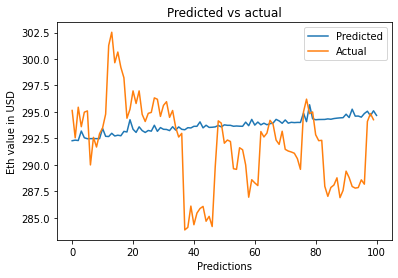

In [14]:
plt.plot(eth_values, label = 'Predicted')
plt.plot(test.head(100)['Close'].values, label = 'Actual')
plt.xlabel('Predictions')
plt.ylabel('Eth value in USD')
# Set a title of the current axes.
plt.title('Predicted vs actual')
plt.legend()
# Display a figure.
plt.show()

In [16]:
mean_squared_error = mean_squared_error(test.head(100)['Close'].values, eth_values[1:])
rmse = sqrt(mean_squared_error)
rmse

4.623185210315153

## Implementation information

Example code for implementation in cadCAD. Each block of code shows what should be configured and mentions which file.
```
# partial_state_update_block.py
partial_state_update_block = [
    {
        # designed.py
        'policies': {
        'action': eth_predictions
        },
        'states': {
            'eth': eth_value_update,
            'eth_filter': eth_filter_params_update,

        }
    },

```

```
# designed.py 
# Behavior
def eth_predictions(params, step, sL, s):
    '''
    Function for taking in current eth timestep data and kalman filter parameters. 
    We will update the kalman filter with the most recent prediction (or sim starting value)
    and make a one step prediction. We will then pass the updated kalman dictionary to it's update
    mechanism along with passing the prediction to its update mechanism
    '''
    observations = s['eth']
    parameters = s['eth_filter'].copy()
    xhatInput = x['xhat']
    PInput = x['P']
    xhatminusInput = x['xhatminus']
    PminusInput = x['Pminus']
    KInput = x['K']
    xhat,P,xhatminus,Pminus,K = kalman_filter_predict(xhatInput,PInput,xhatminusInput,PminusInput,KInput,observation,paramExport=True)
    filter_params = {'xhat':xhat,
             'P':P,
             'xhatminus':xhatminus,
             'Pminus':Pminus,
             'K':K})
             
    prediction = gamma_sample(xhat[-1],fit_shape, fit_loc, fit_scale,0.001)

             
    return {'filter_params': filter_params,'prediction':prediction}
    
# Mechanisms
def eth_filter_params_update(params, step, sL, s, _input):
    x = s['eth_filter'].copy()

    x.update({'xhat':xhat,
             'P':P,
             'xhatminus':xhatminus,
             'Pminus':Pminus,
             'K':K})
    return (y, x)
    

def eth_value_update(params, step, sL, s, _input):
    y = 'eth'
    x = s['eth']
    return (y, x.append(_input['prediction'])
    
```

```
# state_variables.py
state_variables = { 
    'eth': [200], # initial value
    'eth_fitler':{'xhat':xhat,'P':P, # trained prior to initial value
             'xhatminus':xhatminus,'Pminus':Pminus,
             'K':K}
```

## Conclusion

In this notebook, we've read in hourly historical eth data from kaggle, defined functions for fitting and making predictions off of a gamma distribution, which is comminly used in for random walk calculations, and defined functions for de-noising kalman filter. We then validated the structure of these functions and predicted 100 timesteps for evaluation and demonstration purposes. Finally, we provided an overview of how to fit this code into cadCAD. Next steps could include:
* Fefining the Kalman filter hyperparameters
* Refining the gamma prediction tuning parameter
* More thorough model validation

